# Прогнозирование оттока клиентов в "Теледом"

## Описание проекта:
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.
<br><br>
<b>Описание услуг</b>
<b>Оператор предоставляет два основных типа услуг: </b>
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
<br><br>
<b>Также доступны такие услуги:</b>
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
<br><br>
Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.
<br><br>  

## Библиотеки проекта

In [ ]:
%%capture
!pip install -U scikit-learn

# install phik (if not installed yet)
import sys
!"{sys.executable}" -m pip install phik

!pip install shap
import shap


import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import phik
import seaborn as sns

# импортируем функцию
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from IPython.display import Image

# pipeline
# загружаем нужные классы
# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# загружаем дополнительные классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    # добавьте нужное
    RobustScaler
)

# загрузите инструмент для автоподбора гиперпараметров
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные метрики
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

# импортируем модель
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier

from scipy.stats import uniform

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
RANDOM_STATE = 17062024

## Загрузка данных
Загрузите данные и выполните их первичный осмотр.

In [ ]:
try:
    contract = pd.read_csv('/datasets/contract_new.csv', decimal = ',')
    personal = pd.read_csv('/datasets/personal_new.csv', decimal = ',')
    internet = pd.read_csv('/datasets/internet_new.csv', decimal = ',')
    phone = pd.read_csv('/datasets/phone_new.csv', decimal = ',')

except:
    try:
        contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv', decimal = ',')
        personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv', decimal = ',')
        internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv', decimal = ',')
        phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv', decimal = ',')
    except:
        print("Unable to load data")

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.
Данные также находятся в тренажёре, в папке /datasets/.


### contract — информация о договоре:
* customerID — идентификатор абонента;
* BeginDate — дата начала действия договора;
* EndDate — дата окончания действия договора;
* Type — тип оплаты: раз в год-два или ежемесячно;
* PaperlessBilling — электронный расчётный лист;
* PaymentMethod — тип платежа;
* MonthlyCharges — расходы за месяц;
* TotalCharges — общие расходы абонента.


In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


Вывод:
* данные без пропусков;
* тип данных столбцов MonthlyCharges, TotalCharges нужно преобразовать во float64;
* тип данных столбцов BeginDate, EndDate нужно преобразовать в datetime.

### personal — персональные данные клиента:
* customerID — идентификатор пользователя;
* gender — пол;
* SeniorCitizen — является ли абонент пенсионером;
* Partner — есть ли у абонента супруг или супруга;
* Dependents — есть ли у абонента дети.

In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Вывод:
* данные без пропусков;
* тип данных столбца SeniorCitizen желательно преобразовать в object - Yes (1) or No (0), чтобы формализовать кодирование.

### internet— информация об интернет-услугах:
* customerID — идентификатор пользователя;
* InternetService — тип подключения;
* OnlineSecurity — блокировка опасных сайтов;
* OnlineBackup — облачное хранилище файлов для резервного копирования данных;
* DeviceProtection — антивирус;
* TechSupport — выделенная линия технической поддержки;
* StreamingTV — стриминговое телевидение;
* StreamingMovies — каталог фильмов.

In [ ]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Вывод:
* данные без пропусков;
* данных меньше чем в первых двух базах, т.к. не все пользуются интернет-услугами.

### phone— информация об услугах телефонии:
* customerID — идентификатор пользователя;
* MultipleLines — подключение телефона к нескольким линиям одновременно.

In [ ]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Вывод:
* данные без пропусков;
* данных меньше чем в первых двух базах, т.к. не все пользуются услугами телефонии.

## Исследовательский анализ и предобработка данных
Выполните исследовательский анализ каждого датафрейма и при необходимости выполните предобработку. Сделайте выводы об имеющихся признаках: понадобятся ли они для обучения моделей.

### Замена пробелов на np.nan

In [ ]:
# Заменим пробелы в данных на nan

contract['TotalCharges']  = contract['TotalCharges'].replace(r'^\s*$', np.nan, regex=True)

### Пропуски и явные дубликаты

In [ ]:
# Напишем функцию анализа данных на пропуски и дубликаты

def data_analysis(df):
    display(
            "Сумма пропусков:", df.isna().sum(),
            "Явные дубликаты:", df.duplicated().sum()
            )


#### contract_new
— информация о договоре

In [ ]:
data_analysis(contract)

'Сумма пропусков:'

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64

'Явные дубликаты:'

0

* Дубликатов и пропусков в других базах не обнаружено.
* В дальнейшем при использовании модели, наличие пропусков в данных не помешает работе. Так как эти пропуски, будут предобрабатываться на этапе кодирования и масштабирования данных в конвейере обработки, даже если с этим модель может справиться самостоятельно.

### Согласование типов данных

In [ ]:
# Заменим данные с object на float64

contract = contract.astype({'MonthlyCharges': 'float64', 'TotalCharges': 'float64'})

In [ ]:
# Заменим данные с object на datetime

contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(pd.to_datetime(contract['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.date)

In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Данные согласованы со своим форматом

### Статистический анализ

In [ ]:
# Функция для вывода статистического описания

def describe_datasets(datasets):
    # Цикл по каждому набору данных в списке
    for i, dataset in enumerate(datasets):
        # Вывод названия набора данных
        print(f"Dataset {i+1}:")

        # Вывод описательной статистики
        print("Description:")
        print(dataset.describe())

        # Разделитель для лучшей читаемости
        print("\n" + "-"*60 + "\n")

In [ ]:
# Список анализируемых датасетов

datasets = [contract, personal, internet, phone ]

In [ ]:
describe_datasets(datasets)

Dataset 1:
Description:
       MonthlyCharges  TotalCharges
count     7043.000000   7032.000000
mean        64.761692   2118.621822
std         30.090047   2112.736199
min         18.250000     19.050000
25%         35.500000    439.745000
50%         70.350000   1345.275000
75%         89.850000   3239.317500
max        118.750000   9221.380000

------------------------------------------------------------

Dataset 2:
Description:
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

------------------------------------------------------------

Dataset 3:
Description:
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     4742-DRORA     Fiber optic             No           No   
freq             1       

<AxesSubplot:>

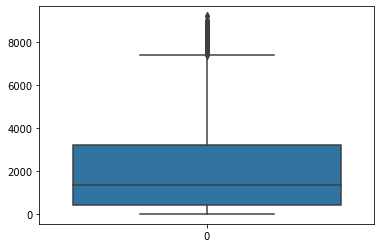

In [ ]:
sns.boxplot(data=contract['TotalCharges'],  orient='v' )

In [ ]:
def data_spread(df, column):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

    df.boxplot(column=column, ax=ax[0])
    ax[0].set_title(f'Диаграмма размаха на столбце {column}')
    ax[0].grid(True)

    ax[1].hist(df[column], bins=200)
    ax[1].set_title(f'Гистограмма на столбце {column}')
    ax[1].grid(True)

    fig.suptitle(f'Разброс данных столбца {column}')

    plt.show()
    print('    ', '-'*104)

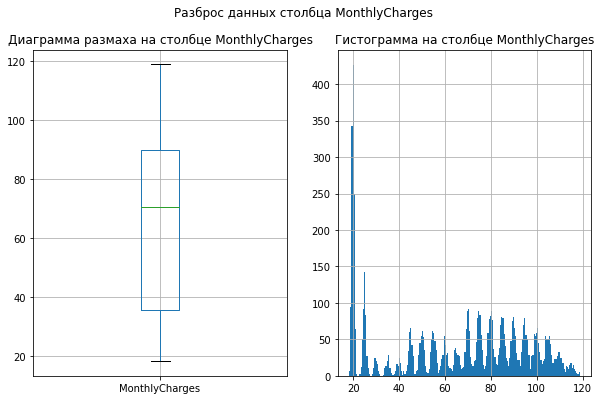

     --------------------------------------------------------------------------------------------------------


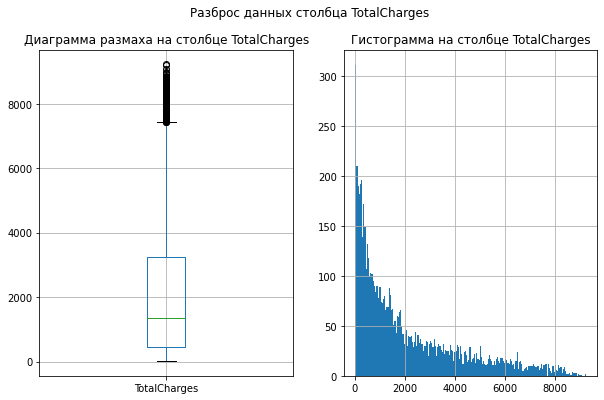

     --------------------------------------------------------------------------------------------------------


In [ ]:
# Разброс данных
for column in ['MonthlyCharges', 'TotalCharges']:
    data_spread(contract, column)

Вывод:
* выбросов в цифировых данных нет

<div class="alert alert-block alert-info">
 Выбросы находящиеся за пределами межквартильного диапазона в 1.5 * IQR, определены в данных 'TotalCharges', но они не являются  результатом ошибки, а отражает редкое, но возможное событие. При этом максимальный критерий выброса равен 3,73, что вполне реалистично для такого типа данных.
<br><br>
Межквартильный диапазон содержит 50% генеральной совокупности, а 1.5 * IQR - около 99%.
</div>

### Типизация данных

In [ ]:
# Оценим данные
personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [ ]:
# Выполним замену согласно правилу используемому в других категориях
personal.loc[personal['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
personal.loc[personal['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'

## Объединение данных
Объедините выбранные вами признаки в один датафрейм по ключу.

In [ ]:
df_full = contract.merge(personal, on='customerID', how='left').merge(internet, on='customerID', how='left') \
                  .merge(phone, on='customerID', how='left')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Вывод:
* Объединение прошло успешно, данные не были потеряны

## Исследовательский анализ и предобработка данных объединённого датафрейма
Выполните исследовательский анализ объединённого датафрейма, визуализируйте распределения признаков и при необходимости выполните предобработку. Проведите корреляционный анализ. Напоминаем, что вы можете использовать не только имеющиеся признаки, но и генерировать новые.

### Замена пропусков в TotalCharges

In [ ]:
# Выведем пропуски в столбце TotalCharges
df_full[df_full['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,No,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,Male,No,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,Female,No,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,Female,No,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,Female,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,Female,No,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Пропуски в столбце TotalCharges соответствуют, клиентам которые только заключили контракты, так как дата BeginDate 2020-02-01, а EndDate отсутствует. Соответственно, такие пропуски можно заменить текущими тратами за месяц.
</div>

In [ ]:
# Заменим пропуски в данных TotalCharge у клиентов, которые заключили контракт меньше месяца назад.
# Заполним его значением трат из столбца MonthlyCharges.

df_full['TotalCharges'].fillna(df_full['MonthlyCharges'], inplace=True)

### Дубликаты

In [ ]:
# Проверка дубликатов пользовательских ID

df_full.index.duplicated().sum()

0

In [ ]:
# Проверка дубликатов данных

df_full.loc[ : , df_full.columns != 'customerID'].duplicated().sum()

4

Вывод:
* Дубликатов в ID пользователей нет;
* Полные дубликаты данных могут быть, вполне вероятно.

### Создание новых признаков

#### Создание целевого признака Churn - отток

In [ ]:
# Оценим пропуски в столбце TotalCharges для индикации вновь подключившихся
# Чтобы определить наличие коротких контрактов
df_full[df_full['TotalCharges'].isnull()].shape

(0, 20)

In [ ]:
df_full[df_full['EndDate'] == '2020-02-01'].shape

(0, 20)

In [ ]:
df_full[df_full['BeginDate'] == '2020-02-01'].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,No,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,20.25,Male,No,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,80.85,Female,No,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,25.75,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,56.05,Female,No,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN


In [ ]:
df_full.iloc[488, 2] = '2020-02-01'

In [ ]:
df_full[df_full['EndDate'].isna()].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


Коротких контрактов нет. Сделаем целевой признак с учётом возможности существования таких контрактов

In [ ]:
df_full[df_full['EndDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,No,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN


In [ ]:
# Создаем целевой признак Churn на основе столбца EndDate: если Churn = 1, значит что клиент от нас ушел, иначе Churn = 0

df_full['Churn'] = 1 # ушёл

In [ ]:
df_full['Churn'].value_counts()

1    7043
Name: Churn, dtype: int64

In [ ]:
# Создадим временный признак 2, быстрого контракта: пришёл и в этом же месяце ушёл

df_full.loc[(df_full['BeginDate'] == '2020-02-01') & (df_full['EndDate'] == '2020-02-01'), 'Churn'] = 2 # быстро ушёл

In [ ]:
df_full['Churn'].value_counts()

1    7042
2       1
Name: Churn, dtype: int64

In [ ]:
# недавно пришёл и ещё не ушёл - отметим классом 0

df_full.loc[(df_full['BeginDate'] == '2020-02-01') & (df_full['EndDate'].isna()), 'Churn'] = 0 # недавно пришёл и ещё не ушёл

In [ ]:
df_full['Churn'].value_counts()

1    7032
0      10
2       1
Name: Churn, dtype: int64

In [ ]:
# Заменим пропуски в столбце 'EndDate' на текущую дату

df_full['EndDate'] = df_full['EndDate'].fillna(pd.to_datetime('2020-02-01'))
df_full['EndDate'] = pd.to_datetime(df_full['EndDate'], format='%Y-%m-%d')

In [ ]:
df_full['Churn'].value_counts()

1    7032
0      10
2       1
Name: Churn, dtype: int64

In [ ]:
# Отметим действующих клиентов, при этом в эту группу не попадут  из группы 2

df_full.loc[(df_full['BeginDate'] != '2020-02-01') & (df_full['EndDate'] == '2020-02-01'), 'Churn'] = 0 # не ушёл

In [ ]:
df_full['Churn'].value_counts()

0    5941
1    1101
2       1
Name: Churn, dtype: int64

In [ ]:
#
df_full.loc[df_full['Churn'] == 2, 'Churn'] = 1 # ушёл

In [ ]:
# Оценим дисбаланс классов

df_full['Churn'].value_counts()

0    5941
1    1102
Name: Churn, dtype: int64

Вывод:
* Добавлены новые более информативные признаки, характеризующие клиентов с точки зрения их вовлеченности в процесс:
** Время жизни клиента;
* Добавлен целевой признак: Churn - оттток. В данных наблюдается дисбаланс классов (0 класс - 5942; 1 класс - 1101), данный факт нужно учесть при разбиении выборок, применением метода - stratify=target;
* Средне время жизни клиентов разных классов различается, что скорее всего будет учтено моделью при прогнозировании.

Заменим все пропуски на значение Absent (отсутствие). Данная услуга для данного клиента, не была в соответствующей базе. Этот пропуск не равен значению No, который говорит об отказе в рамках поключенной услуги. Это относится к признакам: <br>      
 13  OnlineSecurity    5517 non-null   object        <br>
 14  OnlineBackup      5517 non-null   object        <br>
 15  DeviceProtection  5517 non-null   object        <br>
 16  TechSupport       5517 non-null   object        <br>
 17  StreamingTV       5517 non-null   object        <br>
 18  StreamingMovies   5517 non-null   object        <br>
 19  MultipleLines     6361 non-null   object    <br>

In [ ]:
# Заменим все пропуски на Absent - отсутствует. Данная услуга для данного клиента, не была в соответствующей базе.

df_full.fillna('Absent',inplace = True)

 Иногда для модели важно различать услугу, которая не подключена внутри пакета (No), от услуги, неподключенной вместе со всем пакетом (пропуск). Это решается выбором заполнителя, отличным от No. Можно и No использовать. Главное, чтобы метрика модели была от этого лучше.

#### Время жизни клиента - lifetime

In [ ]:
# Время использования тарифа

df_full['lifetime'] = (df_full.EndDate - df_full.BeginDate).dt.days

In [ ]:
# Среднее время сотрудничества клиентов двух категорий

print(df_full[df_full.Churn == 1].lifetime.median()) # ушёл
print(df_full[df_full.Churn != 1].lifetime.median()) # не ушёл

914.5
702.0


In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Вывод:
* Пропуски заменены успешно согласно логике бизнес-процессов

##### Динамика заключения / расторжения договоров

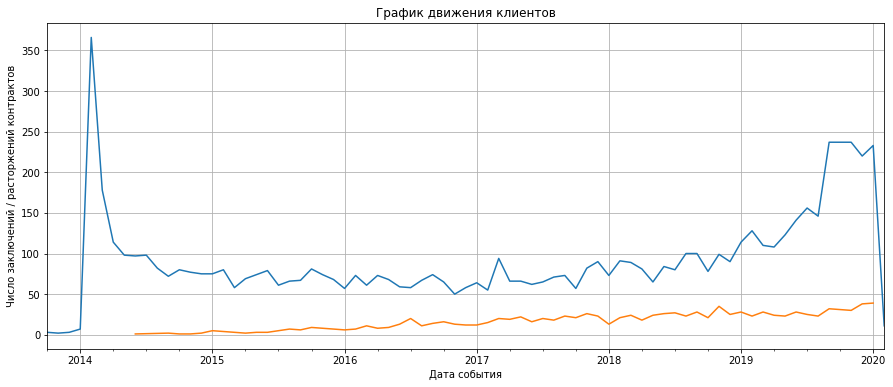

In [ ]:
# Оценим динамику заключения и расторжения договоров

df_full.BeginDate.value_counts().sort_index() \
            .plot(grid=True, figsize=(15,6), title='График движения клиентов', \
                 xlabel= 'Дата события', ylabel= 'Число заключений / расторжений контрактов')

df_full[df_full.EndDate != '2020-02-01'].EndDate.value_counts().sort_index() \
            .plot(grid=True, figsize=(15,6));

В начале 2014 был пик подключений, через полгода был спад до 200% и установилось равновесие. С середины 2017 года наметился новый тренд на увеличение подключений, который продолжидся до 2020 г и составил 100%. Отключаться начали с середины 2014 года и тренд постепенно нарастает. <br>
Эти кривые говорят о динамике развития компании, что позволит нам принимать взвешенные решения, а также понимать структуру договоров.

### Сравнение групп пользователей по категориям
Разделим данные по категориям Churn

In [ ]:
df_full_0 = df_full[df_full['Churn'] == 0] # Рабочий контракт
df_full_0.shape

(5941, 22)

In [ ]:
df_full_1 = df_full[df_full['Churn'] == 1] # Расторгнутый контракт
df_full_1.shape

(1102, 22)

####  'PaperlessBilling', 'SeniorCitizen', 'Partner', 'Dependents', 'gender'

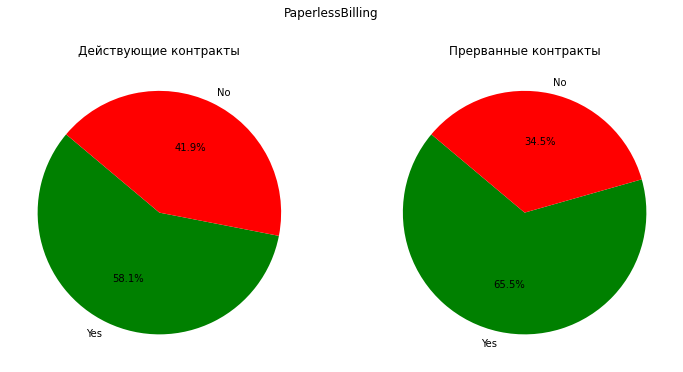

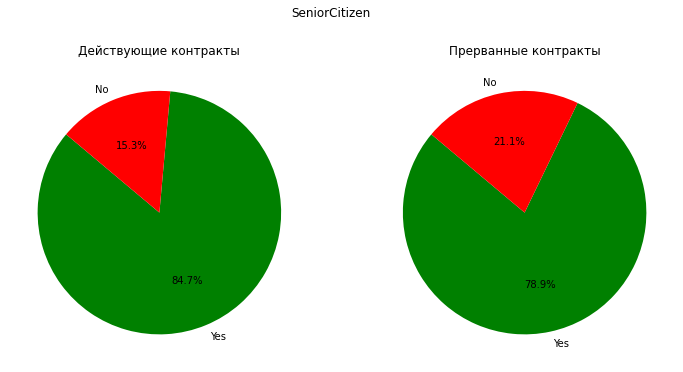

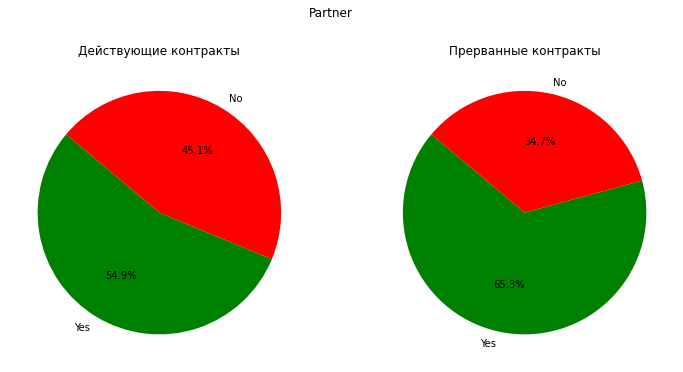

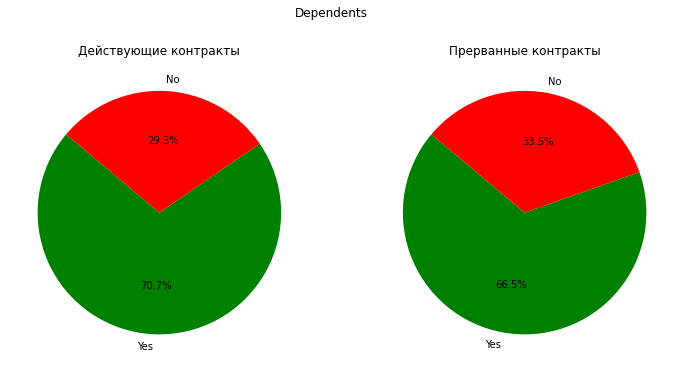

In [ ]:
two_columns = ['PaperlessBilling', 'SeniorCitizen', 'Partner', 'Dependents']

# PaperlessBilling — электронный расчётный лист;
# SeniorCitizen — является ли абонент пенсионером;
# Partner — есть ли у абонента супруг или супруга;
# Dependents — есть ли у абонента дети;

for column in two_columns:

    labels = ['Yes', 'No']

    # Настройка цветов для круговых диаграмм
    colours = {'Yes': 'green',
               'No': 'red'}

    column_vc0 = df_full_0[column].value_counts().reset_index()
    column_vc0.columns = ['unique', 'counts']
    column_vc0.sort_values(by='unique', ascending=False)

    column_vc1 = df_full_1[column].value_counts().reset_index()
    column_vc1.columns = ['unique', 'counts']
    column_vc1.sort_values(by='unique', ascending=False)

    # Создание фигуры и осей для круговых диаграмм
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Первая круговая диаграмма
    ax1.pie(column_vc0['counts'], labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%', startangle=140)
    ax1.set_title('Действующие контракты')

    # Вторая круговая диаграмма
    ax2.pie(column_vc1['counts'], labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%', startangle=140)
    ax2.set_title('Прерванные контракты')

    # Общее заголовок для фигуры
    plt.suptitle(column)

    # Показать круговые диаграммы
    plt.show()

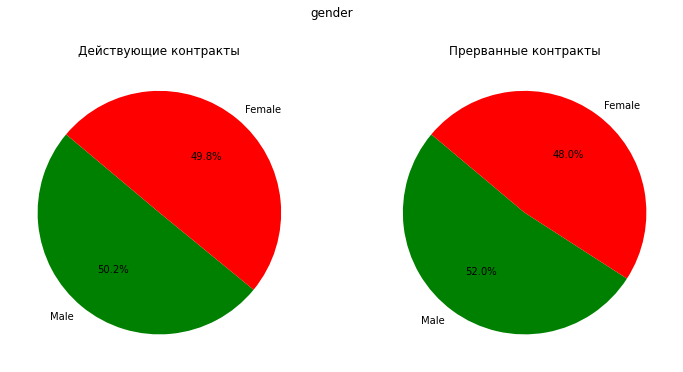

In [ ]:
gender_columns = ['gender']

# gender — пол;

for column in gender_columns:

    labels = ['Male', 'Female']

    # Настройка цветов для круговых диаграмм
    colours = {'Male': 'green',
               'Female': 'red'}

    column_vc0 = df_full_0[column].value_counts().reset_index()
    column_vc0.columns = ['unique', 'counts']
    column_vc0.sort_values(by='unique', ascending=False)

    column_vc1 = df_full_1[column].value_counts().reset_index()
    column_vc1.columns = ['unique', 'counts']
    column_vc1.sort_values(by='unique', ascending=False)

    # Создание фигуры и осей для круговых диаграмм
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Первая круговая диаграмма
    ax1.pie(column_vc0['counts'], labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%', startangle=140)
    ax1.set_title('Действующие контракты')

    # Вторая круговая диаграмма
    ax2.pie(column_vc1['counts'], labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%', startangle=140)
    ax2.set_title('Прерванные контракты')

    # Общее заголовок для фигуры
    plt.suptitle(column)

    # Показать круговые диаграммы
    plt.show()

Гендерное влияние не отслеживается

Значимого гендерного влияния на принятие решения об отключение не наблюдается

Тогда не стоит брать этот признак для обучения модели

##### Влияние параметра на актуальность контракта

Вычислим изменение долей признака в категории, так чтобы значение 1 показывало на отсутствие изменений. Что означало бы отсутствие корреляции отключений с данным признаком. Значение признака < 1 говорит об уменьшении доли (например доля была 0.9, а стала 0,8) - что говорит о влиянии признака на ослабление тренда на отключения. И наоборот.

In [ ]:
two_columns = ['PaperlessBilling', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']

# PaperlessBilling — электронный расчётный лист;
# gender — пол;
# SeniorCitizen — является ли абонент пенсионером;
# Partner — есть ли у абонента супруг или супруга;
# Dependents — есть ли у абонента дети;

for column in two_columns:
    column_vc0 = df_full_0[column].value_counts().reset_index()
    column_vc0.columns = ['unique', 'counts']
    column_vc0.sort_values(by='unique', ascending=False)
    vc0 = column_vc0['counts'].iloc[0] / column_vc0['counts'].sum() # доля признаков yes и male до заключения контракта

    column_vc1 = df_full_1[column].value_counts().reset_index()
    column_vc1.columns = ['unique', 'counts']
    column_vc1.sort_values(by='unique', ascending=False)
    vc1 = column_vc1['counts'].iloc[0] / column_vc1['counts'].sum() # доля признаков yes и male после заключения контракта
    # Общее заголовок для фигуры
    trend = vc1/vc0

    if trend > 1:
        print(f"Влияние параметра {column} усиливает тренд на разрыв контракта")
        print(vc1/vc0)
    else:
        print(f"Влияние параметра {column} ослабляет тренд на разрыв контракта")
        print(vc1/vc0)

Влияние параметра PaperlessBilling усиливает тренд на разрыв контракта
1.1285530038691873
Влияние параметра gender усиливает тренд на разрыв контракта
1.0359169536273904
Влияние параметра SeniorCitizen ослабляет тренд на разрыв контракта
0.9322725418196655
Влияние параметра Partner усиливает тренд на разрыв контракта
1.1910393053662924
Влияние параметра Dependents ослабляет тренд на разрыв контракта
0.9408765448103016


#### 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'

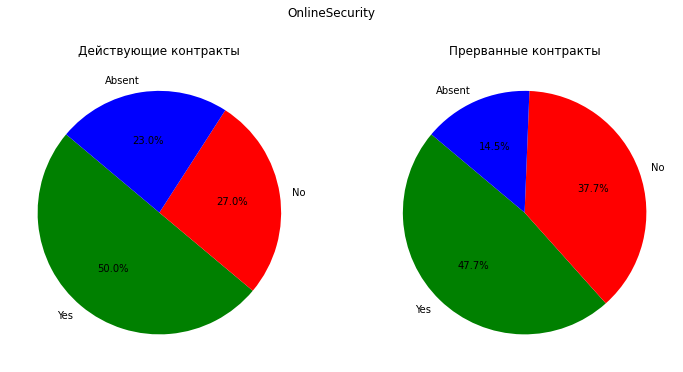

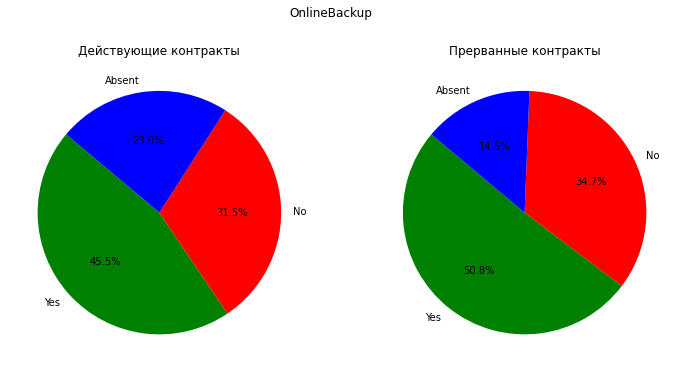

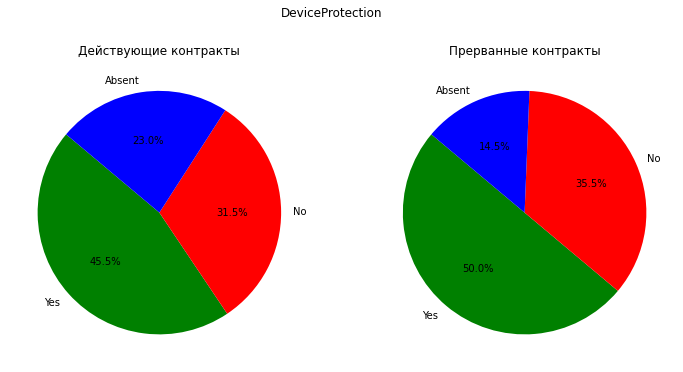

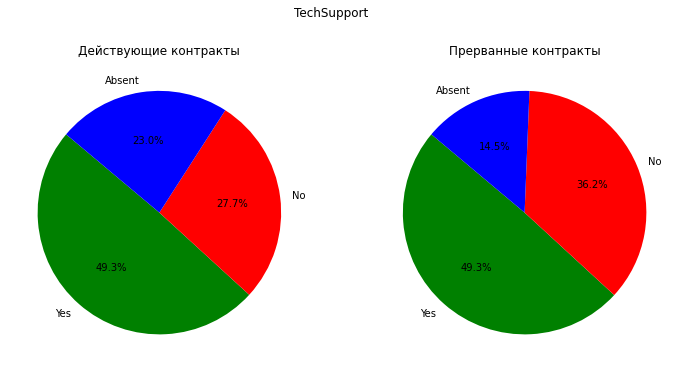

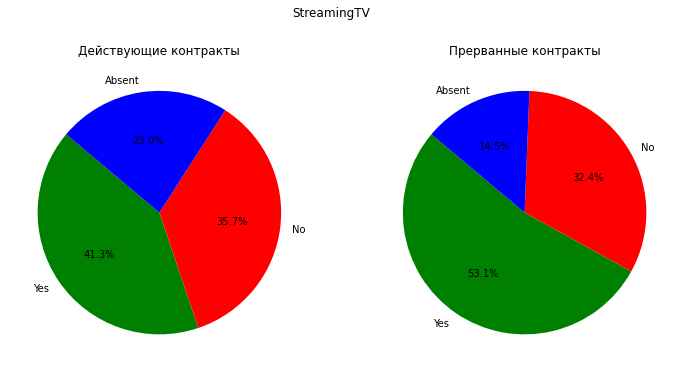

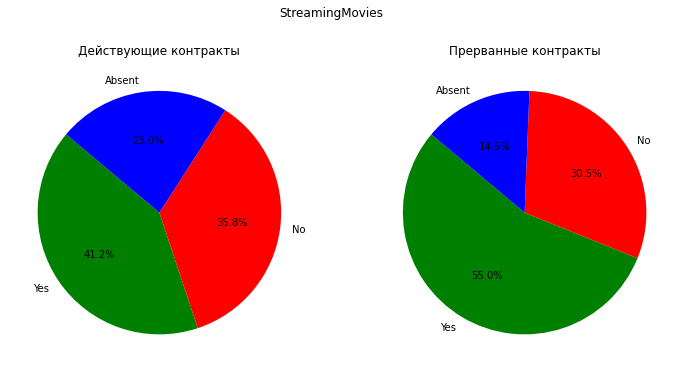

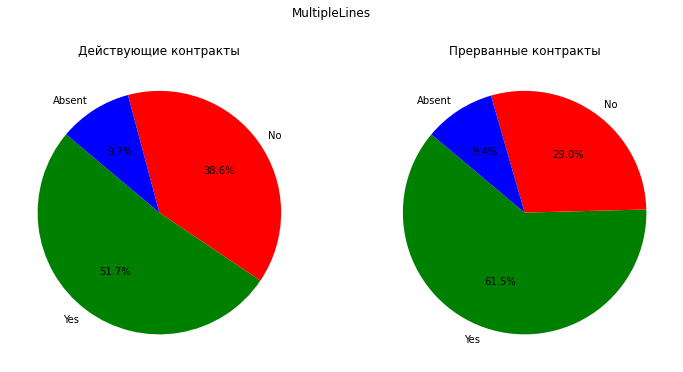

In [ ]:
three_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
               'StreamingTV', 'StreamingMovies', 'MultipleLines']

# OnlineSecurity — блокировка опасных сайтов;
# OnlineBackup — облачное хранилище файлов для резервного копирования данных;
# DeviceProtection — антивирус;
# TechSupport — выделенная линия технической поддержки;
# StreamingTV — стриминговое телевидение;
# StreamingMovies — каталог фильмов;
# MultipleLines — подключение телефона к нескольким линиям одновременно.

for column in three_columns:

    labels = ['Yes', 'No', 'Absent']

    # Настройка цветов для круговых диаграмм
    colours = {'Yes': 'green',
               'No': 'red',
              'Absent': 'blue'}

    column_vc0 = df_full_0[column].value_counts().reset_index()
    column_vc0.columns = ['unique', 'counts']
    column_vc0.sort_values(by='unique', ascending=False)

    column_vc1 = df_full_1[column].value_counts().reset_index()
    column_vc1.columns = ['unique', 'counts']
    column_vc1.sort_values(by='unique', ascending=False)

    # Создание фигуры и осей для круговых диаграмм
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Первая круговая диаграмма
    ax1.pie(column_vc0['counts'], labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%', startangle=140)
    ax1.set_title('Действующие контракты')

    # Вторая круговая диаграмма
    ax2.pie(column_vc1['counts'], labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%', startangle=140)
    ax2.set_title('Прерванные контракты')

    # Общее заголовок для фигуры
    plt.suptitle(column)

    # Показать круговые диаграммы
    plt.show()

##### Влияние параметра на актуальность контракта

In [ ]:
ohe_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
               'StreamingTV', 'StreamingMovies', 'MultipleLines']

# OnlineSecurity — блокировка опасных сайтов;
# OnlineBackup — облачное хранилище файлов для резервного копирования данных;
# DeviceProtection — антивирус;
# TechSupport — выделенная линия технической поддержки;
# StreamingTV — стриминговое телевидение;
# StreamingMovies — каталог фильмов;
# MultipleLines — подключение телефона к нескольким линиям одновременно.

for column in ohe_columns:
    column_vc0 = df_full_0[column].value_counts().reset_index()
    column_vc0.columns = ['unique', 'counts']
    vc0 = column_vc0['counts'].iloc[0] / column_vc0['counts'].sum() # доля признаков yes до заключения контракта

    column_vc1 = df_full_1[column].value_counts().reset_index()
    column_vc1.columns = ['unique', 'counts']
    vc1 = column_vc1['counts'].iloc[0] / column_vc1['counts'].sum() # доля признаков yes после заключения контракта
    # Общее заголовок для фигуры
    trend = vc1/vc0

    if trend > 1:
        print(f"Влияние параметра {column} усиляет тренд на разрыв контракта")
        print(vc1/vc0)
    else:
        print(f"Влияние параметра {column} ослабляет тренд на разрыв контракта")
        print(vc1/vc0)

Влияние параметра OnlineSecurity ослабляет тренд на разрыв контракта
0.9541461383072012
Влияние параметра OnlineBackup усиляет тренд на разрыв контракта
1.1156762615308053
Влияние параметра DeviceProtection усиляет тренд на разрыв контракта
1.0985576923076923
Влияние параметра TechSupport ослабляет тренд на разрыв контракта
0.9991027793091061
Влияние параметра StreamingTV усиляет тренд на разрыв контракта
1.2856900288028366
Влияние параметра StreamingMovies усиляет тренд на разрыв контракта
1.3340183296415664
Влияние параметра MultipleLines усиляет тренд на разрыв контракта
1.190609315606212


#### 'Type', 'InternetService', 'PaymentMethod'

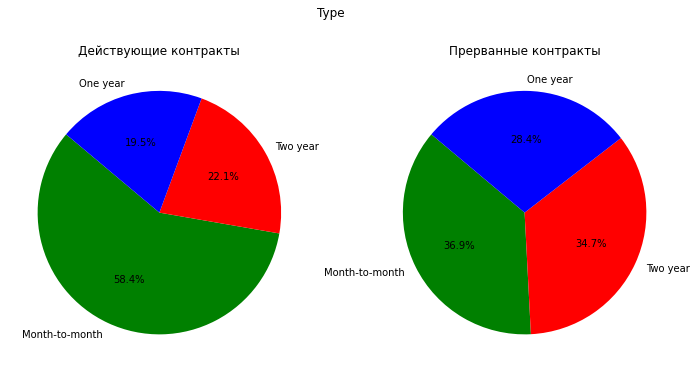

In [ ]:
Type_columns = ['Type']

# Type — тип оплаты: раз в год-два или ежемесячно;

for column in Type_columns:

    labels = ['Month-to-month', 'Two year', 'One year']

    # Настройка цветов для круговых диаграмм
    colours = {'Month-to-month': 'green',
               'Two year': 'red',
              'One year': 'blue'}

    column_vc0 = df_full_0[column].value_counts().reset_index()
    column_vc0.columns = ['unique', 'counts']
    column_vc0.sort_values(by='unique', ascending=False)

    column_vc1 = df_full_1[column].value_counts().reset_index()
    column_vc1.columns = ['unique', 'counts']
    column_vc1.sort_values(by='unique', ascending=False)

    # Создание фигуры и осей для круговых диаграмм
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Первая круговая диаграмма
    ax1.pie(column_vc0['counts'], labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%', startangle=140)
    ax1.set_title('Действующие контракты')

    # Вторая круговая диаграмма
    ax2.pie(column_vc1['counts'], labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%', startangle=140)
    ax2.set_title('Прерванные контракты')

    # Общее заголовок для фигуры
    plt.suptitle(column)

    # Показать круговые диаграммы
    plt.show()

In [ ]:
Type_columns = ['Type']

# Type — тип оплаты: раз в год-два или ежемесячно;

for column in Type_columns:
    column_vc0 = df_full_0[column].value_counts().reset_index()
    column_vc0.columns = ['unique', 'counts']
    vc0_0 = column_vc0['counts'].iloc[0] / column_vc0['counts'].sum() # доля признаков Month-to-month до заключения контракта
    vc0_1 = column_vc0['counts'].iloc[1] / column_vc0['counts'].sum() # доля признаков Two year до заключения контракта
    vc0_2 = column_vc0['counts'].iloc[2] / column_vc0['counts'].sum() # доля признаков One year до заключения контракта

    column_vc1 = df_full_1[column].value_counts().reset_index()
    column_vc1.columns = ['unique', 'counts']
    vc1_0 = column_vc1['counts'].iloc[0] / column_vc1['counts'].sum() # доля признаков Month-to-month после заключения контракта
    vc1_1 = column_vc1['counts'].iloc[1] / column_vc1['counts'].sum() # доля признаков Two year  после заключения контракта
    vc1_2 = column_vc1['counts'].iloc[2] / column_vc1['counts'].sum() # доля признаков One year после заключения контракта
    # Общее заголовок для фигуры
    Month_to_month = vc1_0/vc0_0

    if Month_to_month > 1:
        print(f"Влияние параметра 'Month-to-month' усиливает тренд на разрыв контракта")
        print(vc1_0/vc0_0)
    else:
        print(f"Влияние параметра 'Month-to-month' ослабляет тренд на разрыв контракта")
        print(vc1_0/vc0_0)

    Two_year = vc1_1/vc0_1

    if  Two_year > 1:
        print(f"Влияние параметра 'Two_year' усиливает тренд на разрыв контракта")
        print(vc1_1/vc0_1)
    else:
        print(f"Влияние параметра 'Two_year' ослабляет тренд на разрыв контракта")
        print(vc1_1/vc0_1)

    One_year = vc1_1/vc0_1

    if  One_year > 1:
        print(f"Влияние параметра 'One_year' усиливает тренд на разрыв контракта")
        print(vc1_2/vc0_2)
    else:
        print(f"Влияние параметра 'One_year' ослабляет тренд на разрыв контракта")
        print(vc1_2/vc0_2)

Влияние параметра 'Month-to-month' ослабляет тренд на разрыв контракта
0.6326933623881922
Влияние параметра 'Two_year' усиливает тренд на разрыв контракта
1.5684713661928806
Влияние параметра 'One_year' усиливает тренд на разрыв контракта
1.4546694098504287


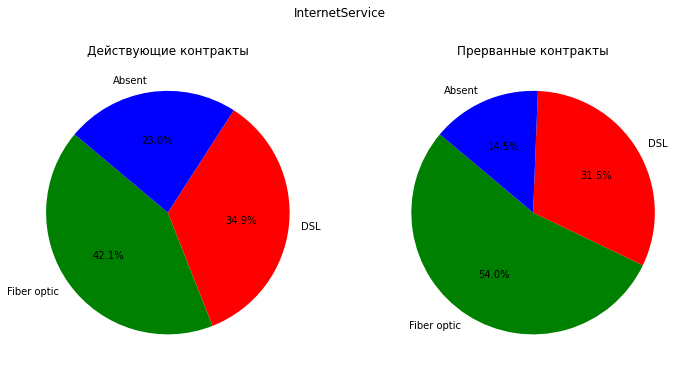

In [ ]:
Type_columns = ['InternetService']

# Type — тип оплаты: раз в год-два или ежемесячно;

for column in Type_columns:

    labels = ['Fiber optic', 'DSL', 'Absent']

    # Настройка цветов для круговых диаграмм
    colours = {'Fiber optic': 'green',
               'DSL': 'red',
              'Absent': 'blue'}

    column_vc0 = df_full_0[column].value_counts().reset_index()
    column_vc0.columns = ['unique', 'counts']
    column_vc0.sort_values(by='unique', ascending=False)

    column_vc1 = df_full_1[column].value_counts().reset_index()
    column_vc1.columns = ['unique', 'counts']
    column_vc1.sort_values(by='unique', ascending=False)

    # Создание фигуры и осей для круговых диаграмм
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Первая круговая диаграмма
    ax1.pie(column_vc0['counts'], labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%', startangle=140)
    ax1.set_title('Действующие контракты')

    # Вторая круговая диаграмма
    ax2.pie(column_vc1['counts'], labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%', startangle=140)
    ax2.set_title('Прерванные контракты')

    # Общее заголовок для фигуры
    plt.suptitle(column)

    # Показать круговые диаграммы
    plt.show()

In [ ]:
Type_columns = ['InternetService']

# Type — тип оплаты: раз в год-два или ежемесячно;

for column in Type_columns:
    column_vc0 = df_full_0[column].value_counts().reset_index()
    column_vc0.columns = ['unique', 'counts']
    vc0_0 = column_vc0['counts'].iloc[0] / column_vc0['counts'].sum() # доля признаков Fiber optic до заключения контракта
    vc0_1 = column_vc0['counts'].iloc[1] / column_vc0['counts'].sum() # доля признаков DSL до заключения контракта
    vc0_2 = column_vc0['counts'].iloc[2] / column_vc0['counts'].sum() # доля признаков One year до заключения контракта

    column_vc1 = df_full_1[column].value_counts().reset_index()
    column_vc1.columns = ['unique', 'counts']
    vc1_0 = column_vc1['counts'].iloc[0] / column_vc1['counts'].sum() # доля признаков Fiber optic после заключения контракта
    vc1_1 = column_vc1['counts'].iloc[1] / column_vc1['counts'].sum() # доля признаков DSL  после заключения контракта
    vc1_2 = column_vc1['counts'].iloc[2] / column_vc1['counts'].sum() # доля признаков One year после заключения контракта
    # Общее заголовок для фигуры
    Fiber_optic = vc1_0/vc0_0

    if Fiber_optic > 1:
        print(f"Влияние параметра 'Fiber optic' усиливает тренд на разрыв контракта")
        print(vc1_0/vc0_0)
    else:
        print(f"Влияние параметра 'Fiber optic' ослабляет тренд на разрыв контракта")
        print(vc1_0/vc0_0)

    DSL = vc1_1/vc0_1

    if  DSL > 1:
        print(f"Влияние параметра 'DSL' усиливает тренд на разрыв контракта")
        print(vc1_1/vc0_1)
    else:
        print(f"Влияние параметра 'DSL' ослабляет тренд на разрыв контракта")
        print(vc1_1/vc0_1)

Влияние параметра 'Fiber optic' усиливает тренд на разрыв контракта
1.2825704563909461
Влияние параметра 'DSL' ослабляет тренд на разрыв контракта
0.9019836818128518


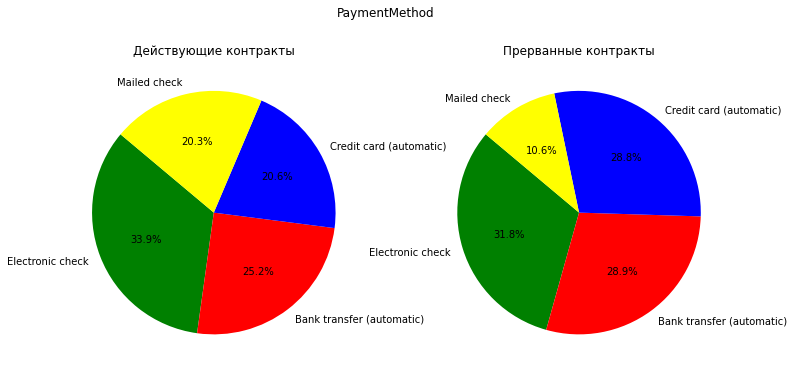

In [ ]:
Type_columns = ['PaymentMethod']

# Type — тип оплаты: раз в год-два или ежемесячно;

for column in Type_columns:

    labels = ['Electronic check', 'Bank transfer (automatic)', 'Credit card (automatic)', 'Mailed check']

    # Настройка цветов для круговых диаграмм
    colours = {'Electronic check': 'green',
               'Bank transfer (automatic)': 'red',
              'Credit card (automatic)': 'blue',
              'Mailed check': 'yellow'}

    column_vc0 = df_full_0[column].value_counts().reset_index()
    column_vc0.columns = ['unique', 'counts']
    column_vc0.sort_values(by='unique', ascending=False)

    column_vc1 = df_full_1[column].value_counts().reset_index()
    column_vc1.columns = ['unique', 'counts']
    column_vc1.sort_values(by='unique', ascending=False)

    # Создание фигуры и осей для круговых диаграмм
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Первая круговая диаграмма
    ax1.pie(column_vc0['counts'], labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%', startangle=140)
    ax1.set_title('Действующие контракты')

    # Вторая круговая диаграмма
    ax2.pie(column_vc1['counts'], labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%', startangle=140)
    ax2.set_title('Прерванные контракты')

    # Общее заголовок для фигуры
    plt.suptitle(column)

    # Показать круговые диаграммы
    plt.show()

In [ ]:
Type_columns = ['PaymentMethod']

# Type — тип оплаты: раз в год-два или ежемесячно;

for column in Type_columns:
    column_vc0 = df_full_0[column].value_counts().reset_index()
    column_vc0.columns = ['unique', 'counts']
    vc0_0 = column_vc0['counts'].iloc[0] / column_vc0['counts'].sum() # доля признаков Electronic check до заключения контракта
    vc0_1 = column_vc0['counts'].iloc[1] / column_vc0['counts'].sum() # доля признаков Bank transfer (automatic) до заключения контракта
    vc0_2 = column_vc0['counts'].iloc[2] / column_vc0['counts'].sum() # доля признаков Credit card (automatic) до заключения контракта
    vc0_3 = column_vc0['counts'].iloc[3] / column_vc0['counts'].sum() # доля признаков One year до заключения контракта

    column_vc1 = df_full_1[column].value_counts().reset_index()
    column_vc1.columns = ['unique', 'counts']
    vc1_0 = column_vc1['counts'].iloc[0] / column_vc1['counts'].sum() # доля признаков Electronic check после заключения контракта
    vc1_1 = column_vc1['counts'].iloc[1] / column_vc1['counts'].sum() # доля признаков Bank transfer (automatic)  после заключения контракта
    vc1_2 = column_vc1['counts'].iloc[2] / column_vc1['counts'].sum() # доля признаков Credit card (automatic) после заключения контракта
    vc1_3 = column_vc1['counts'].iloc[3] / column_vc1['counts'].sum() # доля признаков Mailed check после заключения контракта
    # Общее заголовок для фигуры
    Electronic = vc1_0/vc0_0

    if Electronic > 1:
        print(f"Влияние параметра 'Electronic check' усиливает тренд на разрыв контракта")
        print(vc1_0/vc0_0)
    else:
        print(f"Влияние параметра 'Electronic check' ослабляет тренд на разрыв контракта")
        print(vc1_0/vc0_0)

    Bank = vc1_1/vc0_1

    if  Bank > 1:
        print(f"Влияние параметра 'Bank transfer (automatic)' усиливает тренд на разрыв контракта")
        print(vc1_1/vc0_1)
    else:
        print(f"Влияние параметра 'Bank transfer (automatic)' ослабляет тренд на разрыв контракта")
        print(vc1_1/vc0_1)

    Credit = vc1_2/vc0_2

    if  Credit > 1:
        print(f"Влияние параметра 'Credit card (automatic)' усиливает тренд на разрыв контракта")
        print(vc1_2/vc0_2)
    else:
        print(f"Влияние параметра 'Credit card (automatic)' ослабляет тренд на разрыв контракта")
        print(vc1_2/vc0_2)

    Mailed = vc1_3/vc0_3

    if  Mailed > 1:
        print(f"Влияние параметра 'Mailed check' усиливает тренд на разрыв контракта")
        print(vc1_3/vc0_3)
    else:
        print(f"Влияние параметра 'Mailed check' ослабляет тренд на разрыв контракта")
        print(vc1_3/vc0_3)

Влияние параметра 'Electronic check' ослабляет тренд на разрыв контракта
0.9364205842749254
Влияние параметра 'Bank transfer (automatic)' усиливает тренд на разрыв контракта
1.1467371577369212
Влияние параметра 'Credit card (automatic)' усиливает тренд на разрыв контракта
1.3939485674866696
Влияние параметра 'Mailed check' ослабляет тренд на разрыв контракта
0.5234518905648726


In [ ]:
column_vc0 = df_full_0['PaymentMethod'].value_counts().reset_index()
column_vc0.columns = ['unique', 'counts']
column_vc0.sort_values(by='unique', ascending=False)
column_vc0

,unique,counts
0,Electronic check,2015
1,Mailed check,1495
2,Bank transfer (automatic),1226
3,Credit card (automatic),1205


#### Рисунок числовых параметров в группах

Text(0.5, 0, 'Длительность контракта')

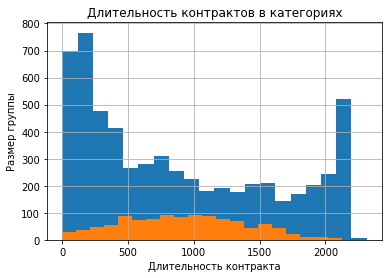

In [ ]:
# Распределение контрактов по длительности в группах

df_full[df_full.Churn == 0].lifetime.hist(bins = 20) # не ушёл
df_full[df_full.Churn == 1].lifetime.hist(bins = 20); # ушёл
plt.title('Длительность контрактов в категориях')
plt.ylabel('Размер группы')
plt.xlabel('Длительность контракта')

Размеры групп подключений по длительности контрактов выражают кривую заключения и расторжения договоров: много коротких контрактов - восходящий тренд на подключение в последний год, и много длинных договоров - интенсивные стартовые процессы компании.

Размер групп по длительности контрактов расторжения: нормальное распределение

Text(0.5, 0, 'Расходы за месяц')

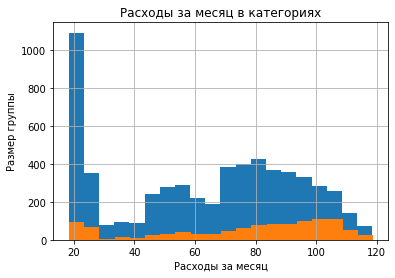

In [ ]:
# Распределение контрактов по расходам за месяц в группах

df_full[df_full.Churn == 0].MonthlyCharges.hist(bins = 20) # не ушёл
df_full[df_full.Churn == 1].MonthlyCharges.hist(bins = 20); # ушёл
plt.title('Расходы за месяц в категориях')
plt.ylabel('Размер группы')
plt.xlabel('Расходы за месяц')

Расторгают договора по группам трат за месяц неравномерно. Наблюдается тендеция на рост расторжений в группе с высокими тратами.

Text(0.5, 0, 'Общие расходы')

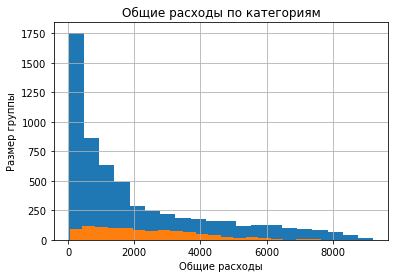

In [ ]:
# Распределение контрактов по общим расходам абонента в группах

df_full[df_full.Churn == 0].TotalCharges.hist(bins = 20) # не ушёл
df_full[df_full.Churn == 1].TotalCharges.hist(bins = 20); # ушёл
plt.title('Общие расходы по категориям')
plt.ylabel('Размер группы')
plt.xlabel('Общие расходы')

Расторгают договора по группам общих расходов неравномерно. Наблюдается тендеция на рост расторжений в группах со средними тратами.

Оценим изменение долей признака в категории. Значение 1 показывает на отсутствие изменений. Это означает отсутствие корреляции отключений с данным признаком. Значение признака < 1 говорит об уменьшении доли (например, в группе 0 доля была 0.9, а в группе 1 стала 0,8) - что говорит о влиянии признака на ослабление тренда на отключение. И наоборот.

Вывод о признках оказывающих положительное влияние на расторжение контрактов - группа 1. Чем больше доля признака в группе, тем вероятнее расторжение:<br>

<b> Корреляция наличия признака в группе расторгнувших контракт:</b>
* Влияние параметра PaperlessBilling усиливает тренд на разрыв контракта 1.1285530038691873
* Влияние параметра gender усиливает тренд на разрыв контракта 1.0359169536273904
* Влияние параметра SeniorCitizen ослабляет тренд на разрыв контракта 0.9322725418196655
* Влияние параметра Partner усиливает тренд на разрыв контракта 1.1910393053662924
* Влияние параметра Dependents ослабляет тренд на разрыв контракта 0.9408765448103016
* Влияние параметра OnlineSecurity ослабляет тренд на разрыв контракта 0.9541461383072012
* Влияние параметра OnlineBackup усиляет тренд на разрыв контракта 1.1156762615308053
* Влияние параметра DeviceProtection усиляет тренд на разрыв контракта 1.0985576923076923
* Влияние параметра TechSupport ослабляет тренд на разрыв контракта 0.9991027793091061
* Влияние параметра StreamingTV усиляет тренд на разрыв контракта <font color="red"> 1.2856900288028366 </font>
* Влияние параметра StreamingMovies усиляет тренд на разрыв контракта <font color="red"> 1.3340183296415664 </font>
* Влияние параметра MultipleLines усиляет тренд на разрыв контракта 1.190609315606212
* Влияние параметра 'Month-to-month' ослабляет тренд на разрыв контракта <font color="green"> 0.6326933623881922 </font>
* Влияние параметра 'Two_year' усиливает тренд на разрыв контракта <font color="red"> 1.5684713661928806 </font>
* Влияние параметра 'One_year' усиливает тренд на разрыв контракта <font color="red"> 1.4546694098504287 </font>
* Влияние параметра 'Fiber optic' усиливает тренд на разрыв контракта <font color="red"> 1.2825704563909461 </font>
* Влияние параметра 'DSL' ослабляет тренд на разрыв контракта 0.9019836818128518
* Влияние параметра 'Electronic check' ослабляет тренд на разрыв контракта 0.9364205842749254
* Влияние параметра 'Bank transfer (automatic)' усиливает тренд на разрыв контракта 1.1467371577369212
* Влияние параметра 'Credit card (automatic)' усиливает тренд на разрыв контракта <font color="red"> 1.3939485674866696 </font>
* Влияние параметра 'Mailed check' ослабляет тренд на разрыв контракта <font color="green"> 0.5234518905648726 </font>


<b> Цифровые признаки: форма трендов отслеживается на гистограммах </b>
* lifetime - длительность контракта;
* MonthlyCharges - расходы за месяц;
* TotalCharges - Общие расходы.

### Удаление исходных для производных признаков

In [ ]:
# df_full.reset_index(inplace = True)

In [ ]:
df_full.drop('EndDate', axis = 1, inplace = True)
df_full.drop('BeginDate', axis = 1, inplace = True)

In [ ]:
df_full.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churn,lifetime
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,Absent,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,Absent,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   object 
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null   object 


Вывод:
* Удалили очевидно коррелирующие признаки - EndDate с Churn; BeginDate с lifetime

В данном проекте эти признаки непригодны для обучения моделей.

### Корреляция признаков

In [ ]:
# Проверим корреляцию всех признаков
# Укажем методу цифровые данные

# interval_cols = df_full.select_dtypes(include=["number"]).columns[0:20]
# interval_cols

Целевая переменная Churn является категориальной (пусть и закодированной), а не числовой.

Из interval_cols нужно исключить 'Churn' и передавать interval_cols в phik_matrix без 'Churn', так как это не числовой признак, а категориальный.

Из числовых признаков убран признак Churn, для правильного понимания алгоритмом  phik_matrix сущности данных. Также исключен из анализа 'customerID', не несущий в данном случае никакой информации.

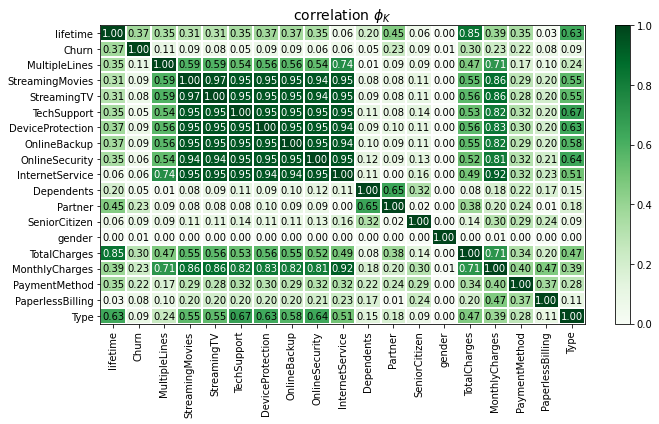

In [ ]:
# корреляционный анализ всех признаков
df = df_full.copy()

df_full = df_full.drop(['customerID'], axis=1)

interval_cols = ['MonthlyCharges', 'TotalCharges', 'lifetime']

phik_overview = phik_matrix(df_full, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.0,
    figsize=(10, 6)
)

При вызове phik_matrix в параметер interval_cols нужно передать список имен числовых признаков. Сейчас к ним была ошибочно причислена категориальная целевая переменная 'Churn'. Это может исказить корреляции (особенно, если целевая переменная была бы не бинарная).

customerID нужно удалить из признаков до расчета корреляций.

Вывод:
* 100% коррелированных данных нет;
* Признак gender обладает нулевой корреляцией и может быть исключен из анализа

Есть ещё признаки с очень низкой корреляцией с целевой переменной, оставим их на удаление, если не сможем достичь нужной скорости или точности предсказания

## Подготовка данных
Выполните подготовку данных для обучения модели. Разделите данные на две выборки, при масштабировании и кодировании учитывайте особенности данных и моделей.

### Оценка данных для кодирования

In [ ]:
# Визуализируем подготовленные данные
df_full.sample(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churn,lifetime
3748,Two year,No,Credit card (automatic),78.90,3787.20,Male,No,No,No,DSL,No,Yes,Yes,Yes,Yes,Yes,No,0,1461
6455,Month-to-month,Yes,Electronic check,44.30,2613.70,Male,No,Yes,No,DSL,No,No,No,No,Yes,Yes,Absent,0,1798
5486,Two year,No,Bank transfer (automatic),87.10,3919.50,Male,No,No,No,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,1,1369
5713,Two year,No,Credit card (automatic),81.35,4145.60,Male,Yes,No,No,DSL,Yes,Yes,Yes,Yes,No,Yes,Yes,0,1492
406,One year,Yes,Bank transfer (automatic),95.40,6239.16,Male,No,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,No,Yes,0,1826


In [ ]:
# Функция для вывода статистического описания

# Проходим в цикле по каждому столбцу датафрейма
for column in df_full.columns:
    # Получаем уникальные значения столбца
    unique_values = df_full[column].unique()
    # Выводим название столбца и его уникальные значения
    print(f'Уникальные значения в колонке {column} : {unique_values}')

Уникальные значения в колонке Type : ['Month-to-month' 'One year' 'Two year']
Уникальные значения в колонке PaperlessBilling : ['Yes' 'No']
Уникальные значения в колонке PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Уникальные значения в колонке MonthlyCharges : [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
Уникальные значения в колонке TotalCharges : [  31.04 2071.84  226.17 ...  325.6   520.8  7251.82]
Уникальные значения в колонке gender : ['Female' 'Male']
Уникальные значения в колонке SeniorCitizen : ['No' 'Yes']
Уникальные значения в колонке Partner : ['Yes' 'No']
Уникальные значения в колонке Dependents : ['No' 'Yes']
Уникальные значения в колонке InternetService : ['DSL' 'Fiber optic' 'Absent']
Уникальные значения в колонке OnlineSecurity : ['No' 'Yes' 'Absent']
Уникальные значения в колонке OnlineBackup : ['Yes' 'No' 'Absent']
Уникальные значения в колонке DeviceProtection : ['No' 'Yes' 'Absent']
Уникальные значения в ко

In [ ]:
# создаём списки с названиями признаков
ohe_columns = ['PaperlessBilling', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', \
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
               'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Type', 'InternetService', 'PaymentMethod']
num_columns = ['MonthlyCharges', 'TotalCharges', 'lifetime']

Вывод:
* Определены категории данных для оптимального кодирования

ohe_columns - бинарные. Они будут одинаково кодироваться и OHE, и OrdinalEncoder. OrdinalEncoder для логистической регрессии подходит только для порядковых категорий, но в этом проекте их нет.

### Разбиение выборок

In [ ]:
# Выполним разбиение выборок на признаки и целевые данные, а также на учебные и тестовые в соотношении 3:1

features = df_full.drop(['Churn', 'gender'], axis=1)
target = df_full['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, stratify=target, random_state=RANDOM_STATE
)

In [ ]:
ohe_columns = ['PaperlessBilling', 'SeniorCitizen', 'Partner', 'Dependents',  \
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
               'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Type', 'InternetService', \
               'PaymentMethod']

In [ ]:
# Pipeline для подготовки данных

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (   # Инициализация SimpleImputer с стратегией 'constant' для замены пропущенных значений
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='No')
        ),
        (   # Инициализация OneHotEncoder с параметром drop='first' для избегания мультиколлинеарности
            # и параметром handle_unknown='ignore' чтобы игнорировать неизвестные категории
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore') # игнорирует «проблемные» объекты
        ),
    ]
)


# создаём пайплайн для подготовки признаков из списка num_columns
num_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# создайте общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns),
    ],
    remainder = 'passthrough'
)

data_preprocessor.fit(X_train, y_train)

print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(fill_value='No',
                                                                strategy='constant')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['PaperlessBilling', 'SeniorCitizen',
                                  'Partner', 'Dependents', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'MultipleLines', 'Type',
                                  'InternetService', 'PaymentMethod']),
                  

Замена пропусков в категориальных данных выполнена ранее. Исправил для категориальных данных замену пропусков по strategy='constant', fill_value='No' <br>
Замена пропусков в цифровых данных выполнена ранее. Оставил strategy='constant', fill_value=0, если появятся другие цифровые данные. <br>

Вывод. Подготовлен конвейер для кодирования данных методами:
* Кодирование: OHE с параметром drop='first' для избегания мультиколлинеарности, и параметром handle_unknown='ignore' чтобы игнорировать неизвестные категории;
* Масштабирование данных выполняется методом StandardScaler.

Стратегия замены пропусков:
* Пропуски заменены ранее
* Для новых признаков, если их добавят, стратегия для категорий - замена на "No". Для цифровых замена на 0.

## Обучение моделей машинного обучения
Обучите как минимум две модели. Хотя бы для одной из них подберите как минимум два гиперпараметра.


### LogisticRegression()

In [ ]:
%%time
# Задаем гиперпараметры для поиска
param_distributions = {
    'logreg__C': uniform(loc=0, scale=3),  # Диапазон значений для параметра регуляризации C
    'logreg__max_iter': [200, 300, 400, 500, 600]  # Список значений для максимального числа итераций
}

CPU times: user 639 µs, sys: 0 ns, total: 639 µs
Wall time: 645 µs


В логистической регресси нельзя испольовать OrdinalEncoder для номинативных категориальных признаков

preprocessor от деревянных моделей для которых допустим OrdinalEncoder нельзя использовать для логистической регрессии. Для линейных моделей не подходит OrdinalEncoder для номинативных категориальных признаков. Для линейных моделей для всех непорядковых категорий нужен OneHotEncoder с параметром drop='first' для предотвращения мультиколлинеарности.

In [ ]:
# пайплайн: подготовка данных
pipeline_LR = Pipeline([
    ('preprocessor', data_preprocessor),  # Стандартизация данных
    ('logreg', LogisticRegression(random_state=RANDOM_STATE))  # Логистическая регрессия
])

In [ ]:
%%time
# Создаем RandomizedSearchCV с выбранным распределением гиперпараметров
randomized_search_LR = RandomizedSearchCV(
    pipeline_LR,  # Pipeline с моделью
    param_distributions=param_distributions,  # Диапазоны гиперпараметров для поиска
    n_iter=10,  # Количество итераций поиска
    cv=5,  # Количество фолдов для кросс-валидации
    verbose=1,  # Уровень детализации вывода
    n_jobs=-1  # Параллельное выполнение на всех CPU
)

CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 18.8 µs


In [ ]:
%%time
randomized_search_LR.fit(X_train, y_train)

Roc_Logistic = randomized_search_LR.best_score_
best_Logistic = randomized_search_LR.best_estimator_

print('Лучшая модель и её параметры:\n\n', best_Logistic)
print ('Метрика ROC_AUC лучшей модели на кроссвалидации:', Roc_Logistic)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['PaperlessBilling',
                                                   'SeniorCitizen', 'Partner',
                                      

Присвоение гиперпараметру max_iter значения побольше, по умолчанию убирает красные предупреждения.

### CatBoostClassifier

Для объективаного сравнения моделей используем cv = 5, сдвинем границы гиперпараметров от экстремума, добавим random_state, используем scoring='roc_auc'

Для деревянных моделей, включая бустинги, масштабирование признаков необязательно, так как деревья устойчивы к разнному масштабу признаков в отличии от линейных моделей. Иногда для числовых признаков можно применить сглаживание выбросов (RobustScaler) и приведение распределения к нормальному (PowerTransformer).

In [ ]:
# Этот скрипт позволяет создать и обучить модель классификации с использованием CatBoostClassifier,
# выполнить стандартизацию данных и подобрать соответствующие гиперпараметры с помощью GridSearchCV.

# Создаем pipeline
pipeline = Pipeline([
    ('preprocessor', data_preprocessor),  # Применяем стандартизацию данных
    ('classifier', CatBoostClassifier(silent=True, random_state = 17062024))  # Используем CatBoostClassifier
])

# Определяем параметры для GridSearchCV
param_grid = {
    'classifier__iterations': [500, 700],
    'classifier__depth': [1, 2, 4],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__l2_leaf_reg': [0.1, 1],
}

# Инициализация GridSearchCV
grid_search_roc_auc = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')

# Обучение модели с подбором гиперпараметров
grid_search_roc_auc.fit(X_train, y_train)

Roc_CatBoost = grid_search_roc_auc.best_score_
best_CatBoost = grid_search_roc_auc.best_params_

# Вывод лучших параметров и лучшего результата обучения
print("Лучшие параметры:", best_CatBoost)
print("Лучшая метрика roc_auc на на кросс-валидации по обучающей выборке:", Roc_CatBoost)

Лучшие параметры: {'classifier__depth': 2, 'classifier__iterations': 700, 'classifier__l2_leaf_reg': 0.1, 'classifier__learning_rate': 0.2}
Лучшая метрика roc_auc на на кросс-валидации по обучающей выборке: 0.9274484990519285


### DecisionTreeClassifier

In [ ]:
%%time

param_grid_DTC = [
   # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__criterion': ['gini', 'entropy'], # Критерий для расчета качества разбиения
        'models__splitter': ['best', 'random'], # Стратегия выбора разбиения на каждом узле
        'models__max_depth': [None, 4, 5, 6], # Максимальная глубина дерева
        'models__max_features': range(12, 17), # Максимальное количество признаков для разбиения
        'models__min_samples_split': range(6, 8), # Минимальное количество образцов для разделения узла
    }
]

CPU times: user 18 µs, sys: 2 µs, total: 20 µs
Wall time: 22.9 µs


In [ ]:
# пайплайн: подготовка данных
pipe_final_DTC = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [ ]:
%%time
GridSearch_DTC = GridSearchCV(
    pipe_final_DTC,
    param_grid_DTC,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

CPU times: user 0 ns, sys: 14 µs, total: 14 µs
Wall time: 17.9 µs


In [ ]:
%%time
GridSearch_DTC.fit(X_train, y_train)


Roc_DecisionTree = GridSearch_DTC.best_score_
best_DecisionTree = GridSearch_DTC.best_estimator_

print('Лучшая модель и её параметры:\n\n', best_DecisionTree)
print ('Метрика ROC_AUC лучшей модели на кроссвалидации:', Roc_DecisionTree)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['PaperlessBilling',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                  

Вывод:

* Созданы пайплайны для трех моделей: DecisionTreeClassifier, CatBoostClassifierи LogisticRegression,
* Определены интревалы гиперпараметров для поиска,
* Использован GridSearchCV для нахождения оптимальных параметров в DecisionTreeClassifier, CatBoostRegressor
* Использован RandomizedSearchCV для нахождения оптимальных параметров в LogisticRegression()

## Выбор лучшей модели
Выберите лучшую модель и проверьте её качество на тестовой выборке.

In [ ]:
result = {'Модель': ["LogisticRegression", "CatBoostClassifier", "DecisionTreeClassifier"],
    "ROC-AUC": [Roc_Logistic, Roc_CatBoost, Roc_DecisionTree],
    "best_estimator_": [best_Logistic, best_CatBoost, best_DecisionTree]
}

# Создаем DataFrame - основную структуру данных в pandas
result = pd.DataFrame(result)
# Устанавливаем опции отображения для вывода длинных строчек полностью
pd.set_option('display.max_colwidth', None)

In [ ]:
result.sort_values(by=['ROC-AUC'], ascending=False)

,Модель,ROC-AUC,best_estimator_
1,CatBoostClassifier,0.927448,"{'classifier__depth': 2, 'classifier__iterations': 700, 'classifier__l2_leaf_reg': 0.1, 'classifier__learning_rate': 0.2}"
0,LogisticRegression,0.863120,"(ColumnTransformer(remainder='passthrough',\n transformers=[('ohe',\n Pipeline(steps=[('simpleImputer_ohe',\n SimpleImputer(fill_value='No',\n strategy='constant')),\n ('ohe',\n OneHotEncoder(drop='first',\n handle_unknown='ignore'))]),\n ['PaperlessBilling', 'SeniorCitizen',\n 'Partner', 'Dependents', 'OnlineSecurity',\n 'OnlineBackup', 'DeviceProtection',\n 'TechSupport', 'StreamingTV',\n 'StreamingMovies', 'MultipleLines', 'Type',\n 'InternetService', 'PaymentMethod']),\n ('num', StandardScaler(),\n ['MonthlyCharges', 'TotalCharges',\n 'lifetime'])]), LogisticRegression(C=1.7480855050500184, max_iter=200, random_state=17062024))"
2,DecisionTreeClassifier,0.790693,"(ColumnTransformer(remainder='passthrough',\n transformers=[('ohe',\n Pipeline(steps=[('simpleImputer_ohe',\n SimpleImputer(fill_value='No',\n strategy='constant')),\n ('ohe',\n OneHotEncoder(drop='first',\n handle_unknown='ignore'))]),\n ['PaperlessBilling', 'SeniorCitizen',\n 'Partner', 'Dependents', 'OnlineSecurity',\n 'OnlineBackup', 'DeviceProtection',\n 'TechSupport', 'StreamingTV',\n 'StreamingMovies', 'MultipleLines', 'Type',\n 'InternetService', 'PaymentMethod']),\n ('num', StandardScaler(),\n ['MonthlyCharges', 'TotalCharges',\n 'lifetime'])]), DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=16,\n min_samples_split=7, random_state=17062024))"


### Лучшая модель - CatBoostClassifier

#### Метрика roc_auc_score

In [ ]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных

# выведем вероятности принадлежности к группе таргета
proba = grid_search_roc_auc.predict_proba(X_test)[:,1]

print(f'Метрика roc_auc на тестовом наборе: {roc_auc_score(y_test, proba)}')

print("\n Лучшие значения гиперпараметров:\n", grid_search_roc_auc.best_params_)

Метрика roc_auc на тестовом наборе: 0.9341372663836431

 Лучшие значения гиперпараметров:
 {'classifier__depth': 2, 'classifier__iterations': 700, 'classifier__l2_leaf_reg': 0.1, 'classifier__learning_rate': 0.2}


In [ ]:
# Посчитаем количество предсказаний класса 1
# [0 - 0,5] - действующий контракт<br>
# [0.5 - 1] - закрытый контракт

# Создаем DataFrame из списка
data = pd.DataFrame({'values': proba})

# Фильтруем значения больше 0.5
filtered_data = data[data['values'] > 0.5]

# Выводим отфильтрованные значения
print(filtered_data)

        values
4     0.784913
17    0.883788
19    0.923599
20    0.552605
35    0.993850
...        ...
1723  0.929561
1732  0.574694
1737  0.755288
1750  0.924509
1751  0.936943

[178 rows x 1 columns]


In [ ]:
# Построим ROC-кривую (Receiver Operating Characteristic curve или кривая характеристик работы приемника)

def plot_roc(model, target, features):
    model_name = str(model).split('(')[0]
    roc_auc = roc_auc_score(target, model.predict(features))
    fpr, tpr, thresholds = roc_curve(target, model.predict_proba(features)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label= model_name + '(area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return round(roc_auc,2), accuracy_score(target, model.predict(features))

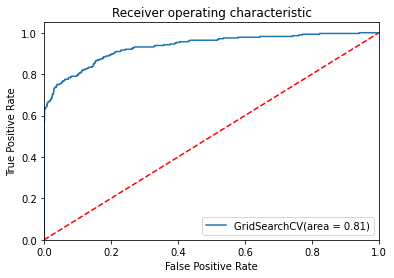

In [ ]:
roc_auc, accuracy = plot_roc(grid_search_roc_auc, y_test, X_test)

Метрика roc_auc_score используется для оценки качества бинарного классификатора. Она основана на построении и измерении площади под кривой ошибок классификации, известной как ROC-кривая (Receiver Operating Characteristic Curve).<br>
ROC-кривая строится путем отображения истинно положительной доли (TPR, True Positive Rate) против ложно положительной доли (FPR, False Positive Rate) при различных порогах дискриминации.
* TPR (чувствительность): доля правильных положительных предсказаний из всех настоящих положительных примеров: TPR = TP / (TP + FN)
* FPR (один минус специфичность): доля ложных положительных предсказаний из всех настоящих отрицательных примеров: FPR = FP / (FP + TN).

#### Confusion - матрица ошибок с метрикой roc_auc_score

In [ ]:
confusion = confusion_matrix(y_test, proba.round(), labels=[0,1]) # до 0.5 - 0 класс; после 0.5 - 1 класс
confusion

array([[1481,    4],
       [ 102,  174]])

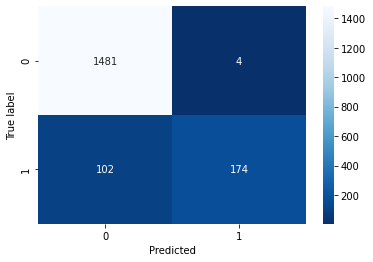

In [ ]:
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues_r')
plt.xlabel('Predicted')
plt.ylabel('True label');

Вывод:
* False Positiv 4 - это те, кто еще не покинул компанию, но скорее всего скоро уйдeт. Модель на основании признаков предсказала разрыв договора.
* False Negativ 102 - это те, кто в реальности уже покинул компанию, а модель с этим не согласна.  

#### Метрика accuracy_score на тесте

In [ ]:
# Предсказания на тестовом наборе
y_pred = grid_search_roc_auc.predict(X_test)

# Оценка точности на тестовом наборе

print("Метрика accuracy_score на тестовом наборе:", accuracy_score(y_test, y_pred))

print("\n Лучшие значения гиперпараметров:\n", grid_search_roc_auc.best_params_)

Метрика accuracy_score на тестовом наборе: 0.9398069278818852

 Лучшие значения гиперпараметров:
 {'classifier__depth': 2, 'classifier__iterations': 700, 'classifier__l2_leaf_reg': 0.1, 'classifier__learning_rate': 0.2}


Точность - это метрика качества, которую в этом проекте анализировать не нужно. Accuracy (долю объектов, для которых мы правильно предсказали класс) не принято называть точностью (долей правильно предсказанных объектов первого класса среди всех объектов, предсказанных этим классом - ушедших в нашем случае). Подробности [здесь](https://academy.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii)

In [ ]:
y_pred.sum(), y_test.sum() # Предсказания и факт первого класса

(178, 276)

In [ ]:
confusion_accuracy = confusion_matrix(y_test, y_pred, labels=[0,1])
confusion_accuracy

array([[1481,    4],
       [ 102,  174]])

Метрикa accuracy_score используется для оценки точности классификационной модели, то есть для оценки того, насколько правильно модель предсказывает классы:
* Correct - предсказания совпавшие с фактом: true positiv и true negative;
* Total - все события

accuracy = Correct / Total = (1481 + 173) / 1761 = 0,939

#### Confusion - матрица ошибок с метрикой accuracy_score

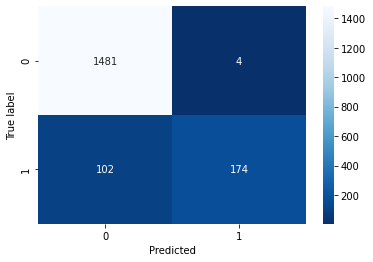

In [ ]:
sns.heatmap(confusion_accuracy, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

#### Важность признаков

In [ ]:
# Оценим преобразованные данные

df_named =pd.DataFrame(grid_search_roc_auc.best_estimator_['preprocessor'].transform(X_train),
                    columns=grid_search_roc_auc.best_estimator_.named_steps['preprocessor'].get_feature_names_out())
df_named.head()

,ohe__PaperlessBilling_Yes,ohe__SeniorCitizen_Yes,ohe__Partner_Yes,ohe__Dependents_Yes,ohe__OnlineSecurity_No,ohe__OnlineSecurity_Yes,ohe__OnlineBackup_No,ohe__OnlineBackup_Yes,ohe__DeviceProtection_No,ohe__DeviceProtection_Yes,...,ohe__Type_One year,ohe__Type_Two year,ohe__InternetService_DSL,ohe__InternetService_Fiber optic,ohe__PaymentMethod_Credit card (automatic),ohe__PaymentMethod_Electronic check,ohe__PaymentMethod_Mailed check,num__MonthlyCharges,num__TotalCharges,num__lifetime
0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.708745,-0.688117,-0.998105
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.538131,-0.925352,-1.222090
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.280804,1.547062,1.006044
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.512583,-0.993305,-1.267473
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.534061,-0.747614,-0.823895


In [ ]:
model = grid_search_roc_auc.best_estimator_.named_steps['classifier']
model

In [ ]:
# список моделей для исследования
result = [model]

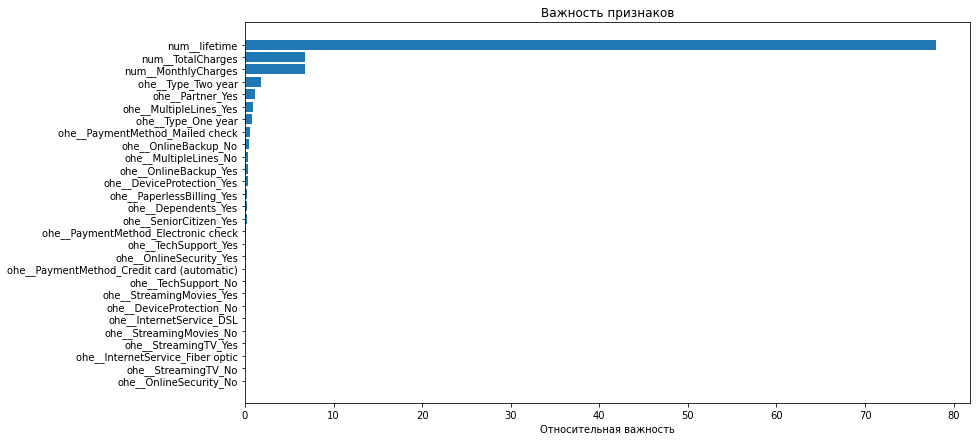

In [ ]:
# Напишем функцию визуализирующую важность признаков из списка моделей графически

def disaplay_features_importances(model, features):
    features = features.columns
    n = len(features)

    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(13, 7))
    plt.title('Важность признаков')
    plt.barh(range(n), importances[indices])
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()

for model_results in result:
    print(model_results)
    disaplay_features_importances(model_results, df_named);

In [ ]:
df_named.columns

Index(['ohe__PaperlessBilling_Yes', 'ohe__SeniorCitizen_Yes',
       'ohe__Partner_Yes', 'ohe__Dependents_Yes', 'ohe__OnlineSecurity_No',
       'ohe__OnlineSecurity_Yes', 'ohe__OnlineBackup_No',
       'ohe__OnlineBackup_Yes', 'ohe__DeviceProtection_No',
       'ohe__DeviceProtection_Yes', 'ohe__TechSupport_No',
       'ohe__TechSupport_Yes', 'ohe__StreamingTV_No', 'ohe__StreamingTV_Yes',
       'ohe__StreamingMovies_No', 'ohe__StreamingMovies_Yes',
       'ohe__MultipleLines_No', 'ohe__MultipleLines_Yes', 'ohe__Type_One year',
       'ohe__Type_Two year', 'ohe__InternetService_DSL',
       'ohe__InternetService_Fiber optic',
       'ohe__PaymentMethod_Credit card (automatic)',
       'ohe__PaymentMethod_Electronic check',
       'ohe__PaymentMethod_Mailed check', 'num__MonthlyCharges',
       'num__TotalCharges', 'num__lifetime'],
      dtype='object')

Вывод о важности признаков для подготовленной модели для удовлетворенности контрактом:
* liftime - длительность сотрудничества. Т.к. на него повлиять нельзя, то признак относительно бесполезный.
* TotalCharges - общие расходы абонента;
* MonthlyCharges - расходы за месяц;
* Type_Two year -  Оплата за 2 года и т.д.

Вывод о дальнейших способах настройки модели:
* Обучать на признаках показавших высокое влияние на тренд (выделенные красным и зелёным).

* Модель улучшают, избавляясь от мультиколлинеарности и не важных для неё признаков, а так же добавления новых сильных признаков, хорошо коррелирующих с целевой переменной.

* Исключить liftime, как не имеющий смысла в анализе, если не гнаться за точностью, а вести маркетинговую работу.

Признак liftime хоть и важен для модели, но не учитывает индивидуальные предпочтения клиентов. Нужно добавить данные о поведении клиентов.

### Бизнес анализ

In [ ]:
# выведем вероятности принадлежности к группе таргета
proba_full = grid_search_roc_auc.predict_proba(features)[:,1]

# совместим данные
df['predict_proba'] = proba_full
df.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churn,lifetime,predict_proba
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,...,No,Yes,No,No,No,No,Absent,0,31,0.006490
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,...,Yes,No,Yes,No,No,No,No,0,1036,0.025796
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,...,Yes,Yes,No,No,No,No,No,0,123,0.007985
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,...,Yes,No,Yes,Yes,No,No,Absent,0,1371,0.051687
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,...,No,No,No,No,No,No,No,0,153,0.017675


#### Группа пользователей, которые скоро покинут компанию

In [ ]:
# Вероятно скоро закроют контракт, так как имеют соответствующие признаки
# Фальшь негатив:
# Churn == 0 - ещё не ушёл
# predict_proba > 0.5 - модель считает, что близок у уходу (можно регулировать вероятность от 0.5 до 1)

df_full_close = df.query('Churn == 0 & predict_proba > 0.5')
df_full_close.shape

(7, 21)

Вывод:
* Выбран один из способов сегментировать маркетинговую группу.
* Таким же образом можно искать другие "слабые" сегменты, например по услугам.
* Размер группы фактически равен значению False Positiv. Но в данном случае больше, так как рассмотрена вся база контрактов, а матрица построена на тестовых данных.

## Общий вывод и рекомендации заказчику
Сделайте общий вывод о проделанной работе: опишите основные этапы работы, полученные результаты и дайте рекомендации для бизнеса.

Вывод о признках оказывающих положительное влияние на расторжение контрактов - группа 1. <br>
Чем больше показатель (значения выделенные красным), тем вероятнее расторжение.<br>
Чем ниже показатель (зелёные значения), тем благотворнее влияние, на стабильность сотрудничества.<br>
Указаны параметры с самым высоким влиянием.

<b> Корреляция наличия признака в группе расторгнувших контракт:</b>
* Влияние параметра StreamingTV усиляет тренд на разрыв контракта <font color="red"> 1.2856900288028366 </font>
* Влияние параметра StreamingMovies усиляет тренд на разрыв контракта <font color="red"> 1.3340183296415664 </font>
* Влияние параметра 'Month-to-month' ослабляет тренд на разрыв контракта <font color="green"> 0.6326933623881922 </font>
* Влияние параметра 'Two_year' усиливает тренд на разрыв контракта <font color="red"> 1.5684713661928806 </font>
* Влияние параметра 'One_year' усиливает тренд на разрыв контракта <font color="red"> 1.4546694098504287 </font>
* Влияние параметра 'Fiber optic' усиливает тренд на разрыв контракта <font color="red"> 1.2825704563909461 </font>
* Влияние параметра 'Credit card (automatic)' усиливает тренд на разрыв контракта <font color="red"> 1.3939485674866696 </font>
* Влияние параметра 'Mailed check' ослабляет тренд на разрыв контракта <font color="green"> 0.5234518905648726 </font>
<br><br>
<b> Цифровые признаки: форма трендов отслеживается на гистограммах </b>
* lifetime - длительность контракта; <br>
Размер групп по длительности контрактов расторжения: нормальное распределение - конракты со средней дительностью расторгаю чаще.<br>
* MonthlyCharges - расходы за месяц;<br>
Расторгают договора по группам трат за месяц неравномерно. Наблюдается тендеция на рост расторжений в группе с высокими тратами.<br>
* TotalCharges - Общие расходы.<br>
Расторгают договора по группам общих расходов неравномерно. Наблюдается тендеция на рост расторжений в группах со средними тратами

Вывод о возможностях маркетингового влияния:
* С точки зрения маркетинга, бизнесу важно удержать клиентов с действующим контрактом, но рисунок признаков которых для модели говорит о нахождении в группе расторгнутых.
* Параметр predict_proba можно сдвигать для увеличения группы потенциальных потерь, для того чтобы оказать возвратное воздействие. Например перевести на месячную оплату.
* Для удержания клиентов, надо усиливать "зелёные" признаки, и ослаблять красные.